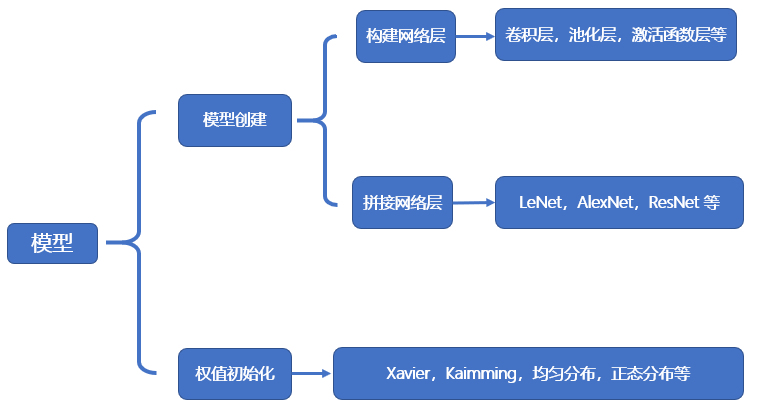

## 网络模型的创建步骤
创建模型有 2 个要素：构建子模块和拼接子模块。如 LeNet 里包含很多卷积层、池化层、全连接层，当我们构建好所有的子模块之后，按照一定的顺序拼接起来。
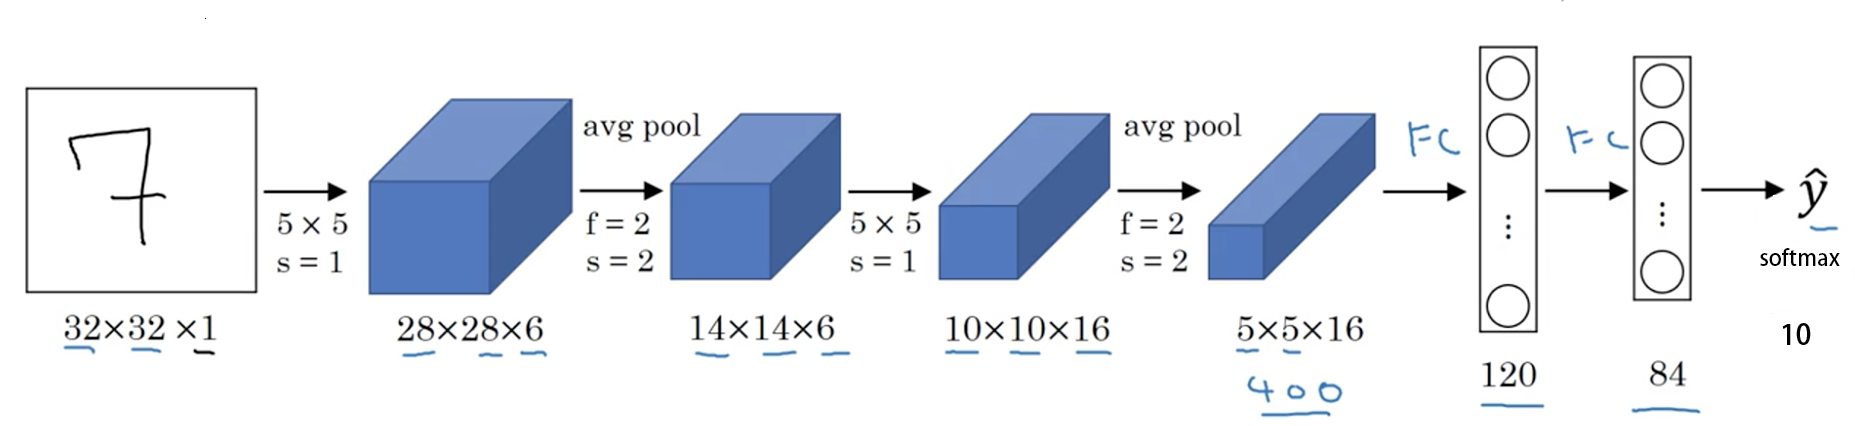
新模型继承nn.Module，必须实现__init__() 方法和forward()方法。其中__init__() 方法里创建子模块，在forward()方法里拼接子模块。

In [ ]:
class LeNet(nn.Module):
    # 子模块创建
    def __init__(self, classes):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, classes)
    # 子模块拼接
    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.max_pool2d(out, 2)
        out = F.relu(self.conv2(out))
        out = F.max_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

torch.nn中包含 4 个模块
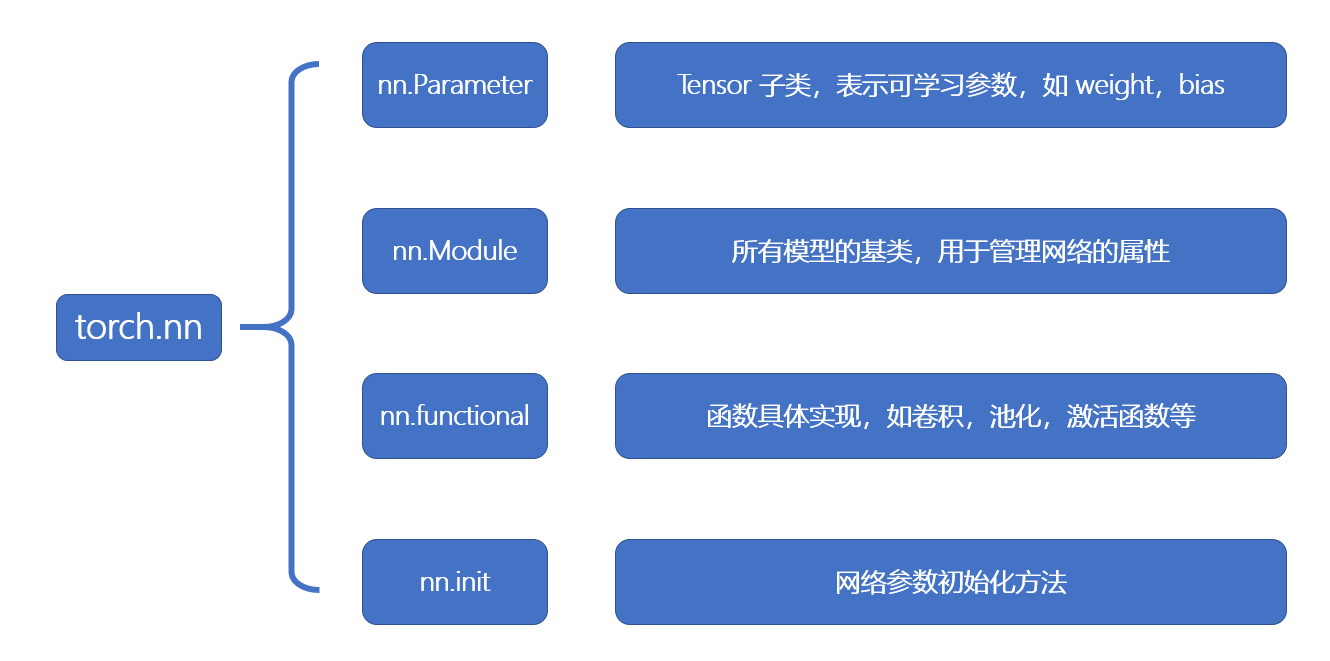
其中所有网络模型都是继承于nn.Module

## 模型容器
- nn.Sequetial：按照顺序包装多个网络层
- nn.ModuleList：像 python 的 list 一样包装多个网络层，可以迭代
- nn.ModuleDict：像 python 的 dict一样包装多个网络层，通过 (key, value) 的方式为每个网络层指定名称。  

nn.Sequetial：按照顺序包装多个网络层
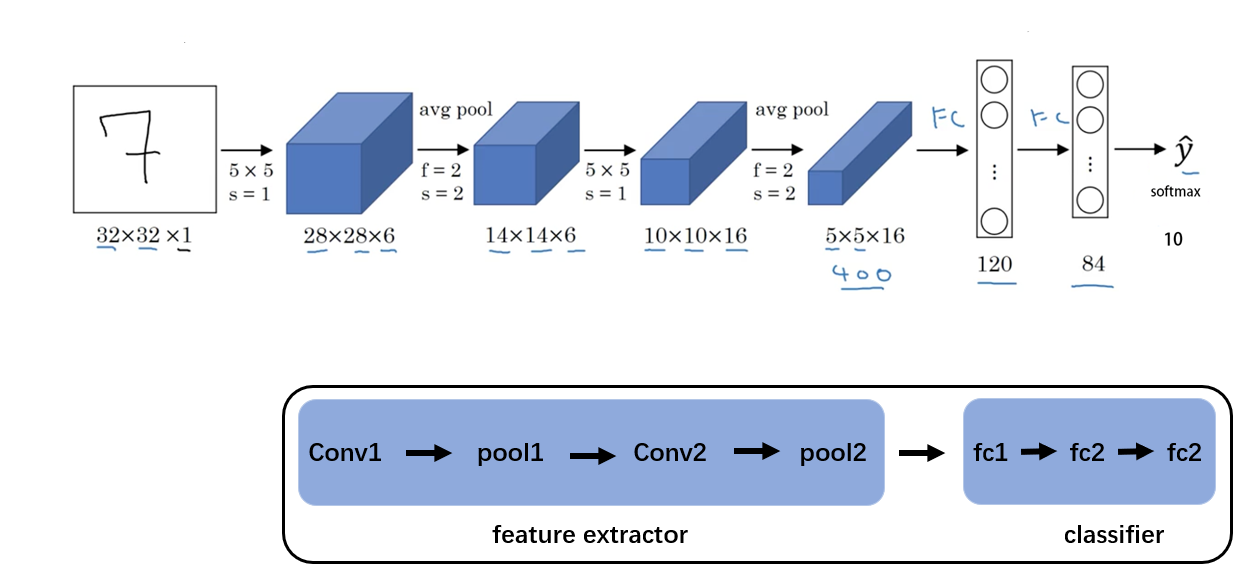

In [ ]:
class LeNetSequetial(nn.Module):
    def __init__(self, classes):
        super(LeNet2, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 6, 5),
            nn.ReLU(),
            nn.AvgPool2d(2, 2),
            nn.Conv2d(6, 16, 5),
            nn.ReLU(),
            nn.AvgPool2d(2, 2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(16*5*5, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size()[0], -1)
        x = self.classifier(x)
        return x

在nn.Sequetial中，里面的每个子网络层 module 是使用序号来索引的，即使用数字来作为 key。一旦网络层增多，难以查找特定的网络层，这种情况可以使用 OrderDict (有序字典)。

In [ ]:
class LeNetSequentialOrderDict(nn.Module):
    def __init__(self, classes):
        super(LeNetSequentialOrderDict, self).__init__()

        self.features = nn.Sequential(OrderedDict({
            'conv1': nn.Conv2d(3, 6, 5),
            'relu1': nn.ReLU(inplace=True),
            'pool1': nn.MaxPool2d(kernel_size=2, stride=2),

            'conv2': nn.Conv2d(6, 16, 5),
            'relu2': nn.ReLU(inplace=True),
            'pool2': nn.MaxPool2d(kernel_size=2, stride=2),
        }))

        self.classifier = nn.Sequential(OrderedDict({
            'fc1': nn.Linear(16*5*5, 120),
            'relu3': nn.ReLU(),

            'fc2': nn.Linear(120, 84),
            'relu4': nn.ReLU(inplace=True),

            'fc3': nn.Linear(84, classes),
        }))
        ...
        ...
        ...

nn.ModuleList是nn.Module的容器，用于包装一组网络层，以迭代的方式调用网络层

In [ ]:
class ModuleList(nn.Module):
    def __init__(self):
        super(ModuleList, self).__init__()
        self.linears = nn.ModuleList([nn.Linear(10, 10) for i in range(20)])

    def forward(self, x):
        for i, linear in enumerate(self.linears):
            x = linear(x)
        return x


net = ModuleList()

print(net)

fake_data = torch.ones((10, 10))

output = net(fake_data)

print(output)

nn.ModuleDict是nn.Module的容器，用于包装一组网络层，以索引的方式调用网络层

In [ ]:
class ModuleDict(nn.Module):
    def __init__(self):
        super(ModuleDict, self).__init__()
        self.choices = nn.ModuleDict({
            'conv': nn.Conv2d(10, 10, 3),
            'pool': nn.MaxPool2d(3)
        })

        self.activations = nn.ModuleDict({
            'relu': nn.ReLU(),
            'prelu': nn.PReLU()
        })

    def forward(self, x, choice, act):
        x = self.choices[choice](x)
        x = self.activations[act](x)
        return x


net = ModuleDict()

fake_img = torch.randn((4, 10, 32, 32))

output = net(fake_img, 'conv', 'relu')
# output = net(fake_img, 'conv', 'prelu')
print(output)

## 容器总结
- nn.Sequetial：顺序性，各网络层之间严格按照顺序执行，常用于 block 构建，在前向传播时的代码调用变得简洁
- nn.ModuleList：迭代行，常用于大量重复网络构建，通过 for 循环实现重复构建
- nn.ModuleDict：索引性，常用于可选择的网络层

### AlexNet

In [ ]:
class AlexNet(nn.Module):

    def __init__(self, num_classes=1000):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x